In [1]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader
from skimage.measure import compare_ssim, compare_mse
from sklearn.preprocessing import RobustScaler
from monai.networks.nets import UNet

%autoreload 2
from networks import *
from utils import set_device, set_seed
from losses import AWLoss
from datasets import UndersampledUltrasoundDataset3D


import matplotlib.pyplot as plt
import progressbar
import plotly.express as px
import plotly.graph_objects as go

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK2at10TensorBase21__dispatch_contiguousEN3c1012MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


## Training Setup

In [10]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=1200
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)


# Losses
l2loss     = nn.MSELoss(reduction="sum")
awloss     = AWLoss(filter_dim=2, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)


Cuda installed! Running on GPU 0 NVIDIA GeForce RTX 2080 Ti!


# MRI Dataset 

In [3]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def resize(x, nc, h, w):
    return torch.nn.functional.interpolate(x.unsqueeze(0).unsqueeze(0), size=(nc, h, w)).squeeze(0).squeeze(0)

def robust_scalar(x):
    shape = x.shape
    rs = RobustScaler()
    x = rs.fit_transform(x.flatten(start_dim=1))
    return torch.tensor(x.reshape(shape), dtype=torch.float32)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x



{'name': 'UndersampledUltrasoundDataset3D', 'path': '/media/dekape/HDD/Ultrasound-MRI_volumes/173940', 'maxsamples': None, 'transform': Compose(
    Lambda()
    Lambda()
    Lambda()
), 'undersample_width': (1, 1, 3), 'mode': 'mri', 'fill': 0.0, 'len': 1} 

torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


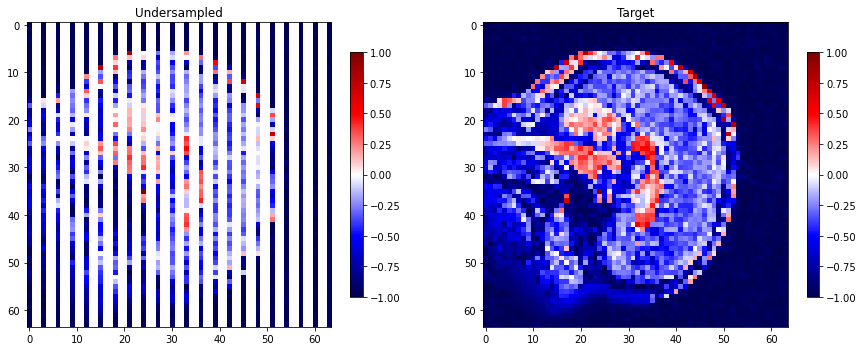

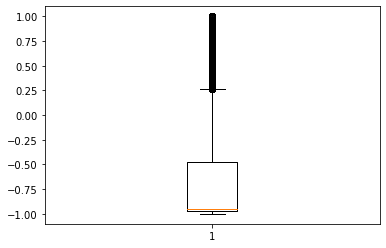

{'max': tensor(1.),
 'min': tensor(-1.),
 'mean': tensor(-0.2414),
 'std': tensor(0.4148),
 'shape': torch.Size([64, 64, 64])}

In [4]:
# Dataset
path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI_volumes/173940")
train_transform = Compose([
                    Lambda(lambda x: resize(x, 64, 64, 64)),
                    # Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x)),
                    # Lambda(lambda x: robust_scalar(x)),
                    Lambda(lambda x: scale2range(x, [-1, 1])),
                    # Normalize(0., 1.),
                    ])
trainds = UndersampledUltrasoundDataset3D(path, 
                                        mode="mri",
                                        transform=train_transform,
                                        undersample_width=(1,1,3))
print(trainds, "\n")

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

# Sample for visualisation
x_sample, y_sample = trainds[0]
print(x_sample.shape, y_sample.shape)

idx = int(x_sample.shape[0]/2)
vmin, vmax, cmap =  None, None, "seismic"
fig, axs = plt.subplots(1,2, figsize=(15,15))

im = axs[0].imshow(x_sample[idx], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs[0], shrink=0.3)
axs[0].set_title("Undersampled")

im = axs[1].imshow(y_sample[idx], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs[1], shrink=0.3)
axs[1].set_title("Target")
plt.show()

plt.boxplot(y_sample.flatten().numpy())
plt.show()

trainds.info(nsamples=1)

## Model 

In [5]:
def make_model(channels=64):
    return UNet(
    spatial_dims=2,
    in_channels=channels,
    out_channels=channels,
    channels=(16, 32, 64, 128, 256),
    strides=tuple([2 for i in range(channels)]), 
    num_res_units=2,
    act="mish",
).to(device)

print(make_model())

/home/dekape/miniconda3/lib/python3.7/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 60 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
      )
      (residual): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (

## Train and Validate Functions

In [6]:
def train(model, train_loader, optimizer, criterion, wmse=0., device="cpu"):
    """ Trains one epoch"""
    model.train()
    
    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="sum")(recon, target)
        combied_loss = loss + wmse*mse

        # Backprop and optim step
        combied_loss.backward()
        optimizer.step()  
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

def validate(model, train_loader, criterion, device="cpu"):
    """ Validates loss of a data loader of an autoencoder """
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        for i , (X, target) in enumerate(train_loader):
            X, target = X.to(device), target.to(device)
            
            # Forward Pass
            recon = torch.tanh(model(X))

            # Evaluate losses
            loss  = criterion(recon, target)
            
            total_loss += loss / len(train_loader)
    return total_loss

# Training

In [7]:
def train_model(model, optimizer, loss, train_loader, wmse=0., valid_loader=None, nepochs=150, log_frequency=10, sample_input=None, sample_target=None, device="cpu"):
    print("\n\nTraining started ...")
    train_losses, valid_losses, mse = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train epoch
            epoch_loss, mse_loss = train(model, train_loader, optimizer, loss, wmse, device)
            # validate
            # ssim score, aco_diff = compare_ssim(ela_real, aco_real, full=True, gaussian_weights=True)
            train_losses.append(epoch_loss.item())
            mse.append(mse_loss.item())
            bar.update(epoch)
            
            # Logging
            log = {"epoch": epoch, "loss": epoch_loss.item(), "mse (weight %.2f)"%wmse:mse_loss}
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                # Figure for plotting
                fig, axs = plt.subplots(2,3, figsize=(15, 15))
                axs = axs.flatten()

                # Plot losses
                axs[0].plot(train_losses, label="train")
                axs[0].plot(valid_losses, label="valid")
                axs[0].legend()
                axs[0].set_title(str(loss))
                axs[0].set_xlabel("epoch")

                axs[1].plot(mse)
                axs[1].set_xlabel("epoch")
                axs[1].set_title("MSE [Loss weight %.2f]"%wmse)

                # Plots
                if sample_input is not None:
                    idx = int(sample_input.shape[0]/2)

                    # Model forward pass
                    model.eval()
                    X = sample_input.unsqueeze(0).to(device)
                    recon = torch.tanh(model(X))[0]

                    # Plot sample input
                    im = axs[3].imshow(sample_input[idx])#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[3], shrink=0.5)
                    axs[3].set_title("Input idx %g"%idx)

                    # Plot reconstruction
                    im = axs[4].imshow(recon[idx].cpu().detach().numpy())#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[4], shrink=0.5)
                    axs[4].set_title("Reconstruction idx %g"%idx)

                    
                    if sample_target is not None:
                        # Plot target input
                        im = axs[5].imshow(sample_target[idx])#, vmin=X.min(), vmax=X.max())
                        fig.colorbar(im, ax=axs[5], shrink=0.5)
                        axs[5].set_title("Target idx %g"%idx)

                        # Loss evaluation and filters
                        print(recon.shape, sample_target.shape)
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        if "awloss" in str(loss).lower():
                            v, T = loss.filters[0], loss.T
                            
                            # Plot filter
                            axs[2].plot(v.flatten().cpu().detach().numpy(), label="Wiener Filter")
                            axs[2].set_ylim(None, 1.1)
                            axs[2].legend()
                            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                        else:
                            pass


            plt.show()



Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 60 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 285881.4375, 'mse (weight 0.00)': tensor(285881.4375, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


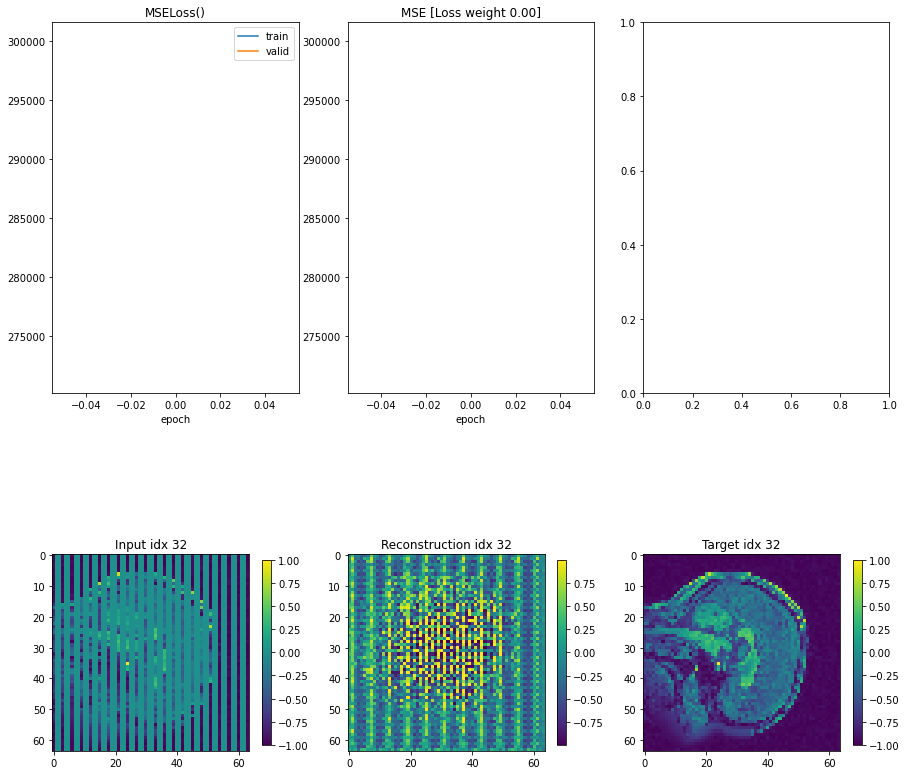

  0% (1 of 150) |                        | Elapsed Time: 0:00:01 ETA:   0:03:43
  1% (2 of 150) |                        | Elapsed Time: 0:00:02 ETA:   0:02:49
  2% (3 of 150) |                        | Elapsed Time: 0:00:03 ETA:   0:02:30
  2% (4 of 150) |                        | Elapsed Time: 0:00:03 ETA:   0:01:54
  3% (5 of 150) |                        | Elapsed Time: 0:00:04 ETA:   0:01:53
  4% (6 of 150) |                        | Elapsed Time: 0:00:05 ETA:   0:01:53
  4% (7 of 150) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:52
  5% (8 of 150) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:52
  6% (9 of 150) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:51
  6% (10 of 150) |#                      | Elapsed Time: 0:00:08 ETA:   0:01:50
  7% (11 of 150) |#                      | Elapsed Time: 0:00:09 ETA:   0:01:48
  8% (12 of 150) |#                      | Elapsed Time: 0:00:10 ETA:   0:01:48
  8% (13 of 150) |#                     


 {'epoch': 149, 'loss': 10890.9189453125, 'mse (weight 0.00)': tensor(10890.9189, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


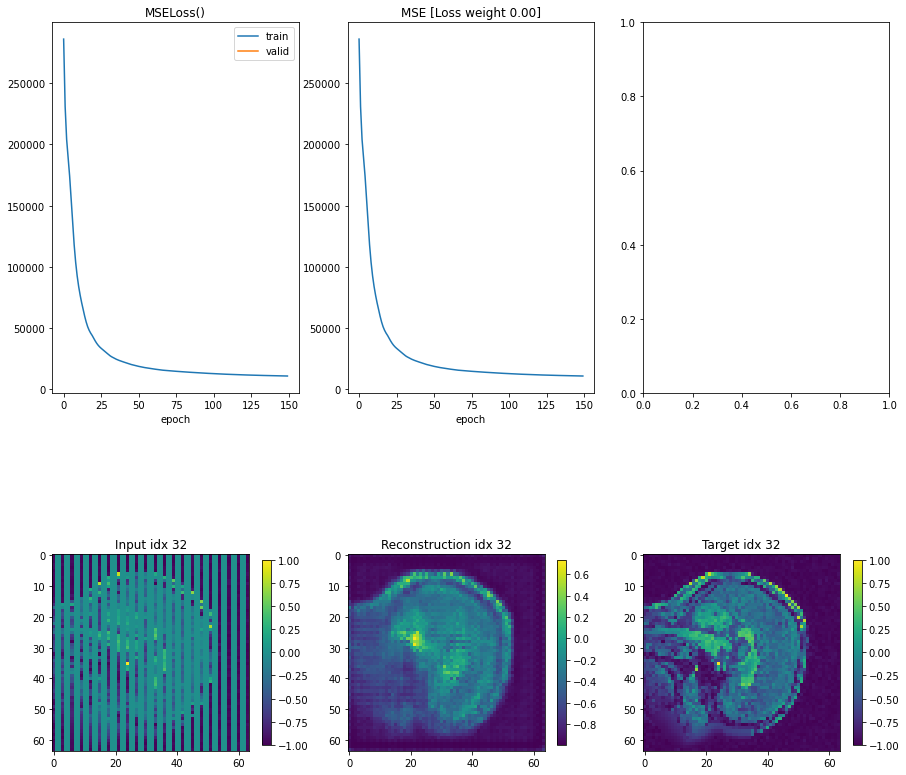

100% (150 of 150) |######################| Elapsed Time: 0:01:58 Time:  0:01:58


In [8]:
model = make_model(channels=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, optimizer, l2loss, train_loader, wmse=0., valid_loader=None, nepochs=150, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)



Training started ...


[W Copy.cpp:240] Warning: Casting complex values to real discards the imaginary part (function operator())
N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 44.49256134033203, 'mse (weight 0.00)': tensor(285471.1875, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 861010


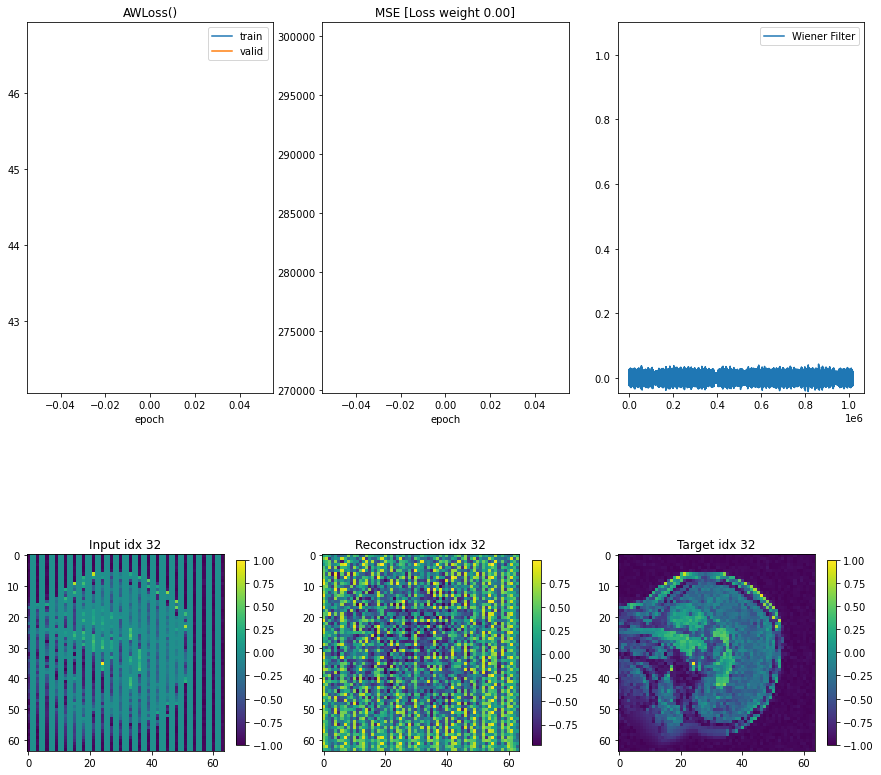

  0% (1 of 300) |                        | Elapsed Time: 0:00:01 ETA:   0:09:16
  0% (2 of 300) |                        | Elapsed Time: 0:00:02 ETA:   0:06:38
  1% (3 of 300) |                        | Elapsed Time: 0:00:03 ETA:   0:05:45
  1% (4 of 300) |                        | Elapsed Time: 0:00:04 ETA:   0:04:01
  1% (5 of 300) |                        | Elapsed Time: 0:00:05 ETA:   0:04:02
  2% (6 of 300) |                        | Elapsed Time: 0:00:05 ETA:   0:04:02
  2% (7 of 300) |                        | Elapsed Time: 0:00:06 ETA:   0:04:01
  2% (8 of 300) |                        | Elapsed Time: 0:00:07 ETA:   0:03:58
  3% (9 of 300) |                        | Elapsed Time: 0:00:08 ETA:   0:03:57
  3% (10 of 300) |                       | Elapsed Time: 0:00:09 ETA:   0:03:56
  3% (11 of 300) |                       | Elapsed Time: 0:00:10 ETA:   0:03:57
  4% (12 of 300) |                       | Elapsed Time: 0:00:10 ETA:   0:03:58
  4% (13 of 300) |                      


 {'epoch': 299, 'loss': 27.20639991760254, 'mse (weight 0.00)': tensor(246443.7188, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 814514


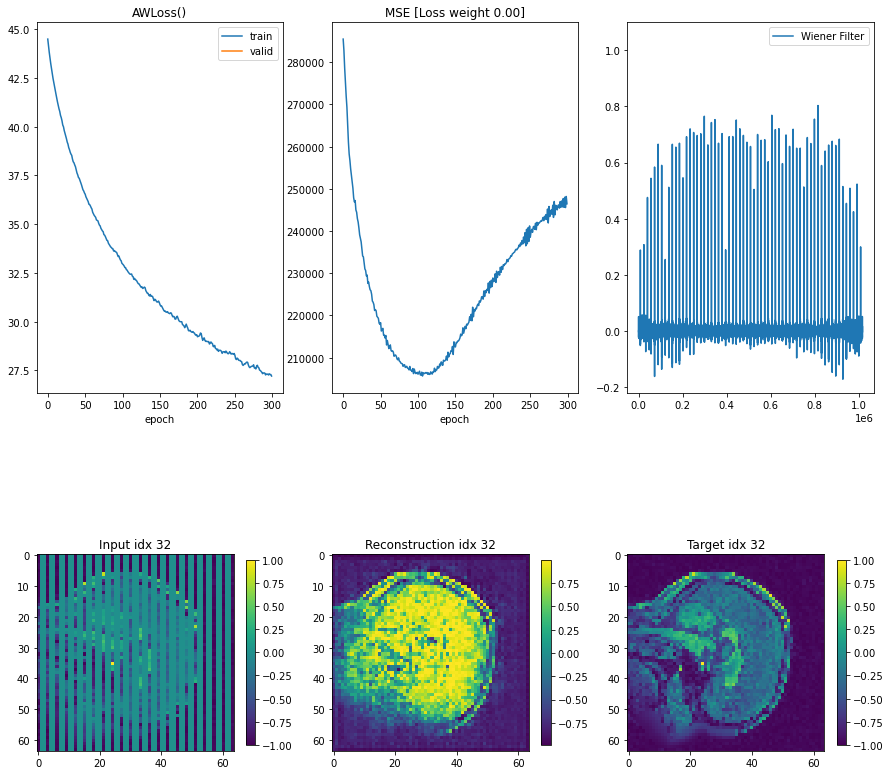

100% (300 of 300) |######################| Elapsed Time: 0:04:07 Time:  0:04:07


In [9]:
model = make_model(channels=x_sample.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, awloss, train_loader, wmse=0.0, valid_loader=None, nepochs=nepochs, log_frequency=nepochs, sample_input=x_sample, sample_target=y_sample, device=device)



Training started ...


[W Copy.cpp:240] Warning: Casting complex values to real discards the imaginary part (function operator())
N/A% (0 of 1200) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 44.57329559326172, 'mse (weight 0.00)': tensor(285881.4375, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 444167


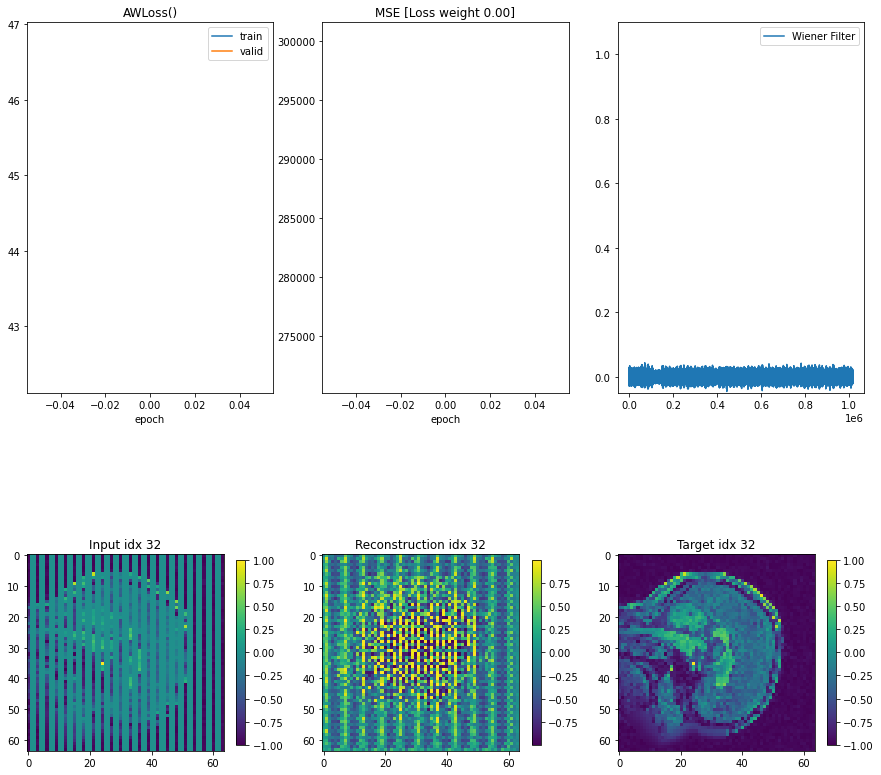

  0% (1 of 1200) |                       | Elapsed Time: 0:00:01 ETA:   0:39:27
  0% (2 of 1200) |                       | Elapsed Time: 0:00:02 ETA:   0:28:10
  0% (3 of 1200) |                       | Elapsed Time: 0:00:03 ETA:   0:24:30
  0% (4 of 1200) |                       | Elapsed Time: 0:00:04 ETA:   0:17:06
  0% (5 of 1200) |                       | Elapsed Time: 0:00:05 ETA:   0:17:07
  0% (6 of 1200) |                       | Elapsed Time: 0:00:06 ETA:   0:17:06
  0% (7 of 1200) |                       | Elapsed Time: 0:00:07 ETA:   0:17:00
  0% (8 of 1200) |                       | Elapsed Time: 0:00:07 ETA:   0:16:59
  0% (9 of 1200) |                       | Elapsed Time: 0:00:08 ETA:   0:16:52
  0% (10 of 1200) |                      | Elapsed Time: 0:00:09 ETA:   0:16:53
  0% (11 of 1200) |                      | Elapsed Time: 0:00:10 ETA:   0:16:49
  1% (12 of 1200) |                      | Elapsed Time: 0:00:11 ETA:   0:16:53
  1% (13 of 1200) |                     


 {'epoch': 300, 'loss': 32.35721206665039, 'mse (weight 0.00)': tensor(6164.5176, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 56451


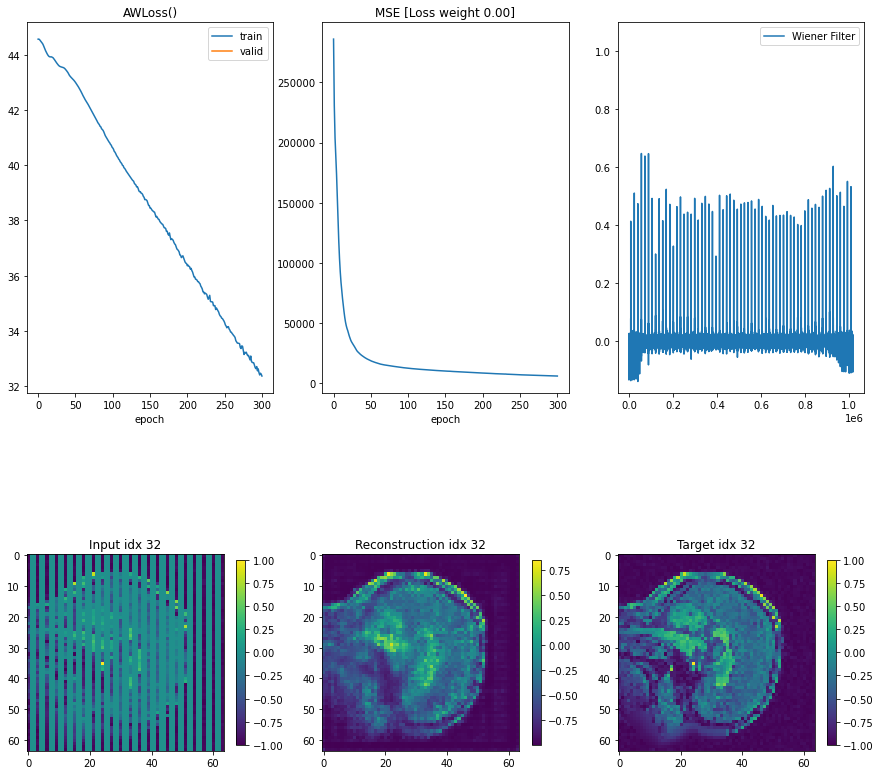

 25% (301 of 1200) |#####                | Elapsed Time: 0:04:19 ETA:   0:21:00
 25% (302 of 1200) |#####                | Elapsed Time: 0:04:19 ETA:   0:21:04
 25% (303 of 1200) |#####                | Elapsed Time: 0:04:20 ETA:   0:18:17
 25% (304 of 1200) |#####                | Elapsed Time: 0:04:21 ETA:   0:12:49
 25% (305 of 1200) |#####                | Elapsed Time: 0:04:22 ETA:   0:12:43
 25% (306 of 1200) |#####                | Elapsed Time: 0:04:23 ETA:   0:12:48
 25% (307 of 1200) |#####                | Elapsed Time: 0:04:24 ETA:   0:12:44
 25% (308 of 1200) |#####                | Elapsed Time: 0:04:25 ETA:   0:12:45
 25% (309 of 1200) |#####                | Elapsed Time: 0:04:25 ETA:   0:12:38
 25% (310 of 1200) |#####                | Elapsed Time: 0:04:26 ETA:   0:12:42
 25% (311 of 1200) |#####                | Elapsed Time: 0:04:27 ETA:   0:12:40
 26% (312 of 1200) |#####                | Elapsed Time: 0:04:28 ETA:   0:12:43
 26% (313 of 1200) |#####               


 {'epoch': 600, 'loss': 25.189640045166016, 'mse (weight 0.00)': tensor(3570.8110, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 88709


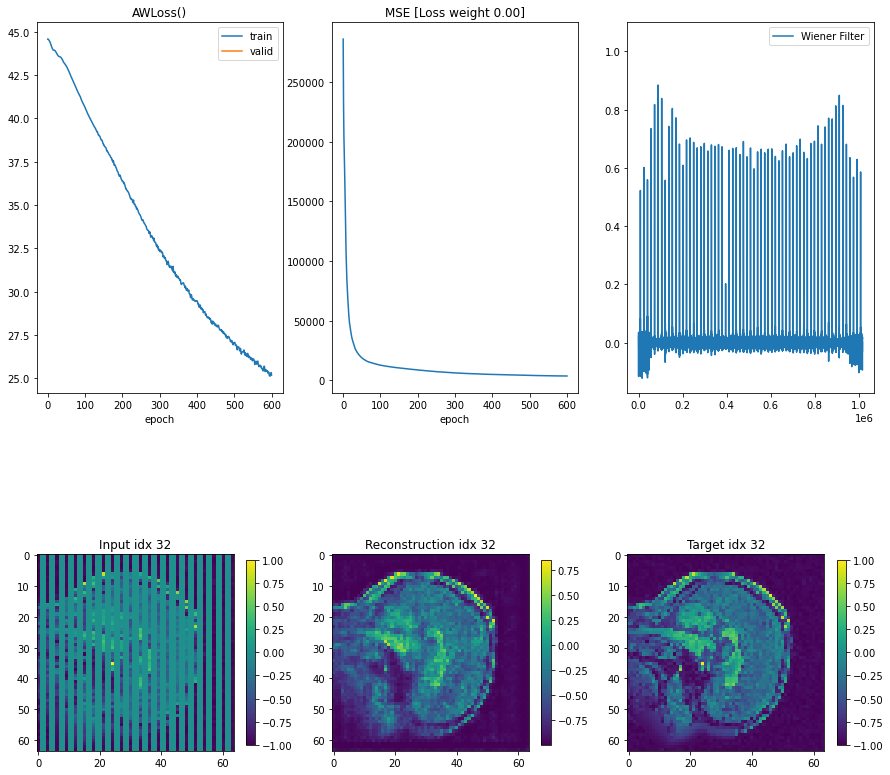

 50% (601 of 1200) |##########           | Elapsed Time: 0:08:36 ETA:   0:13:54
 50% (602 of 1200) |##########           | Elapsed Time: 0:08:36 ETA:   0:13:53
 50% (603 of 1200) |##########           | Elapsed Time: 0:08:37 ETA:   0:12:04
 50% (604 of 1200) |##########           | Elapsed Time: 0:08:38 ETA:   0:08:29
 50% (605 of 1200) |##########           | Elapsed Time: 0:08:39 ETA:   0:08:26
 50% (606 of 1200) |##########           | Elapsed Time: 0:08:40 ETA:   0:08:25
 50% (607 of 1200) |##########           | Elapsed Time: 0:08:41 ETA:   0:08:23
 50% (608 of 1200) |##########           | Elapsed Time: 0:08:42 ETA:   0:08:24
 50% (609 of 1200) |##########           | Elapsed Time: 0:08:42 ETA:   0:08:23
 50% (610 of 1200) |##########           | Elapsed Time: 0:08:43 ETA:   0:08:21
 50% (611 of 1200) |##########           | Elapsed Time: 0:08:44 ETA:   0:08:22
 51% (612 of 1200) |##########           | Elapsed Time: 0:08:45 ETA:   0:08:23
 51% (613 of 1200) |##########          


 {'epoch': 900, 'loss': 21.71739959716797, 'mse (weight 0.00)': tensor(2630.5283, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 88709


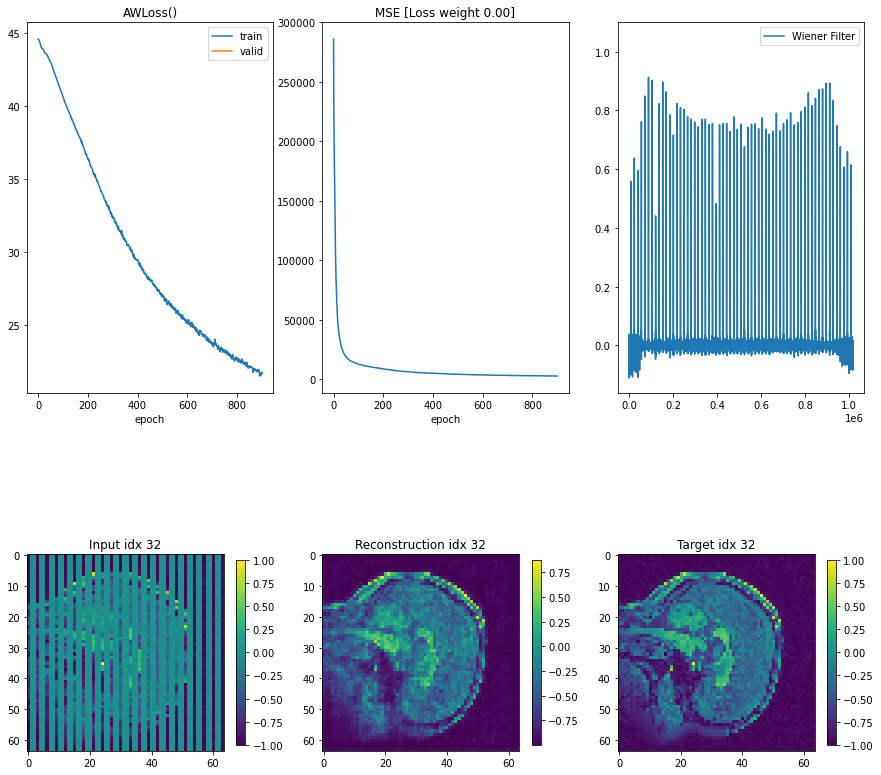

 75% (901 of 1200) |###############      | Elapsed Time: 0:12:53 ETA:   0:07:06
 75% (902 of 1200) |###############      | Elapsed Time: 0:12:53 ETA:   0:07:04
 75% (903 of 1200) |###############      | Elapsed Time: 0:12:54 ETA:   0:06:06
 75% (904 of 1200) |###############      | Elapsed Time: 0:12:55 ETA:   0:04:10
 75% (905 of 1200) |###############      | Elapsed Time: 0:12:56 ETA:   0:04:09
 75% (906 of 1200) |###############      | Elapsed Time: 0:12:57 ETA:   0:04:08
 75% (907 of 1200) |###############      | Elapsed Time: 0:12:58 ETA:   0:04:07
 75% (908 of 1200) |###############      | Elapsed Time: 0:12:59 ETA:   0:04:07
 75% (909 of 1200) |###############      | Elapsed Time: 0:12:59 ETA:   0:04:05
 75% (910 of 1200) |###############      | Elapsed Time: 0:13:00 ETA:   0:04:06
 75% (911 of 1200) |###############      | Elapsed Time: 0:13:01 ETA:   0:04:04
 76% (912 of 1200) |###############      | Elapsed Time: 0:13:02 ETA:   0:04:03
 76% (913 of 1200) |###############     


 {'epoch': 1199, 'loss': 19.653745651245117, 'mse (weight 0.00)': tensor(2177.9263, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 104838


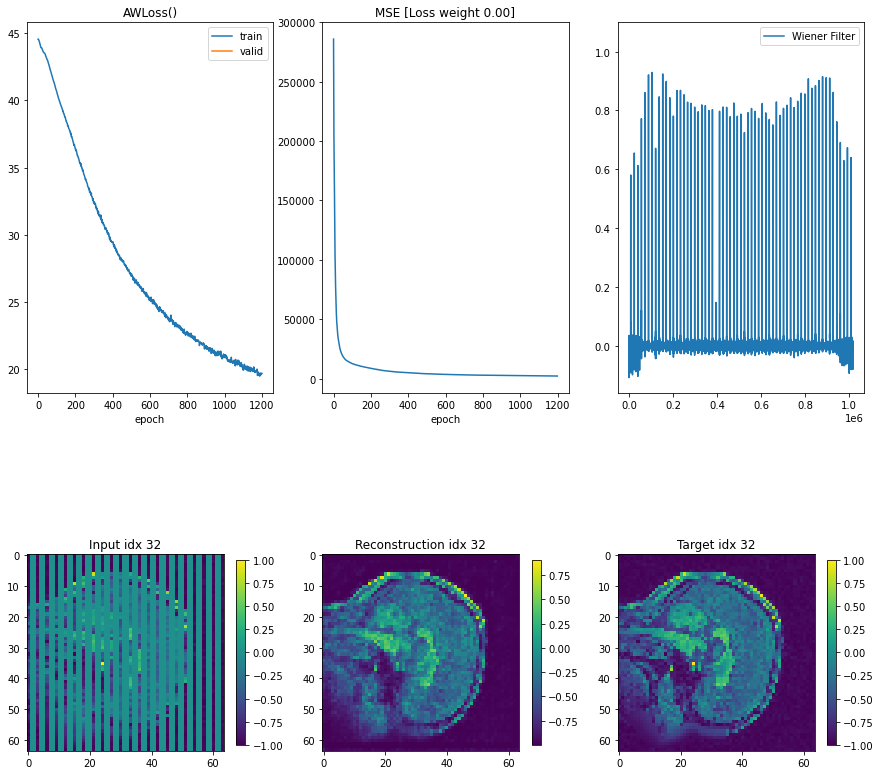

100% (1200 of 1200) |####################| Elapsed Time: 0:17:07 Time:  0:17:07


In [9]:
model = make_model(channels=x_sample.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, awloss, train_loader, wmse=1e-3, valid_loader=None, nepochs=nepochs, log_frequency=300, sample_input=x_sample, sample_target=y_sample, device=device)

Normalisation / Activation [-1, 1], outliers can be dangerous in t1 values

Joint AWLoss and MSE

Frequency continuation

Resize channels / Volumetric data with one channel?
3D FFT -- multigauss generation fails at large dimensions :'(

Larger batch / Validation and test set

SSMI (??)
